In [51]:
import sys
import pandas as pd
import numpy as np

from utils import pre_all
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [53]:
print(f"파이썬 버전 : {sys.version}")
print(f"pandas 버전 : {pd.__version__}")
print(f"numpy 버전 : {np.__version__}")

파이썬 버전 : 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
pandas 버전 : 2.1.4
numpy 버전 : 1.26.4


In [54]:
# train_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/train.csv')[['ID','timestamp','supply(kg)', 'price(원/kg)']]
# test_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/test.csv')[['ID','timestamp']]
train_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/train.csv')
test_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/test.csv')

In [55]:
train_df['item_id'] = train_df.ID.str[0:6]
test_df['item_id'] = test_df.ID.str[0:6]

In [56]:
train, test = pre_all(train_df, test_df)

전처리 전 train 크기 : (59397, 8)
전처리 전 test 크기 : (1092, 6)
=================전처리 중=================
전처리 후 train 크기 : (59397, 16)
전처리 후 test 크기 : (1092, 16)


In [8]:
# make static_features_df
static_features_df = train.loc[:, ['item_id', 'item', 'corporation', 'location']]
static_features_df = static_features_df.drop_duplicates()
print(static_features_df.head())

  item_id item corporation location
0  TG_A_J   TG           A        J
1  CB_A_S   CB           A        S
2  RD_D_J   RD           D        J
3  BC_D_J   BC           D        J
4  CB_F_J   CB           F        J


In [9]:
train.drop(columns=['ID', 'item', 'corporation', 'location'], inplace=True)
test.drop(columns=['ID'], inplace=True)

In [10]:
print(train.head())
print(test.head())

   timestamp  supply  price item_id  year  month  day  week_day  year_month  \
0 2019-01-01     0.0    0.0  TG_A_J  2019      1    1         1           0   
1 2019-01-01     0.0    0.0  CB_A_S  2019      1    1         1           0   
2 2019-01-01     0.0    0.0  RD_D_J  2019      1    1         1           0   
3 2019-01-01     0.0    0.0  BC_D_J  2019      1    1         1           0   
4 2019-01-01     0.0    0.0  CB_F_J  2019      1    1         1           0   

   week  week_num  holiday  
0     1         1        1  
1     1         1        1  
2     1         1        1  
3     1         1        1  
4     1         1        1  
   timestamp item corporation location  supply  price item_id  year  month  \
0 2023-03-04   TG           A        J     NaN    NaN  TG_A_J  2023      3   
1 2023-03-04   TG           E        S     NaN    NaN  TG_E_S  2023      3   
2 2023-03-04   BC           B        J     NaN    NaN  BC_B_J  2023      3   
3 2023-03-04   TG           E        J 

In [11]:
# # create time-varying covariates
# # Create a pivot table to transform the DataFrame
# pivot_table = train.pivot_table(index='timestamp', columns='item_id', values='price', aggfunc='first')
# pivot_table.columns = [c + "_prev_price" for c in pivot_table.columns]

In [12]:
# pivot_table.columns

Index(['BC_A_J_prev_price', 'BC_A_S_prev_price', 'BC_B_J_prev_price',
       'BC_B_S_prev_price', 'BC_C_J_prev_price', 'BC_C_S_prev_price',
       'BC_D_J_prev_price', 'BC_E_J_prev_price', 'BC_E_S_prev_price',
       'CB_A_J_prev_price', 'CB_A_S_prev_price', 'CB_D_J_prev_price',
       'CB_E_J_prev_price', 'CB_F_J_prev_price', 'CR_A_J_prev_price',
       'CR_B_J_prev_price', 'CR_C_J_prev_price', 'CR_D_J_prev_price',
       'CR_D_S_prev_price', 'CR_E_J_prev_price', 'CR_E_S_prev_price',
       'RD_A_J_prev_price', 'RD_A_S_prev_price', 'RD_C_S_prev_price',
       'RD_D_J_prev_price', 'RD_D_S_prev_price', 'RD_E_J_prev_price',
       'RD_E_S_prev_price', 'RD_F_J_prev_price', 'TG_A_J_prev_price',
       'TG_A_S_prev_price', 'TG_B_J_prev_price', 'TG_B_S_prev_price',
       'TG_C_J_prev_price', 'TG_C_S_prev_price', 'TG_D_J_prev_price',
       'TG_D_S_prev_price', 'TG_E_J_prev_price', 'TG_E_S_prev_price'],
      dtype='object')

In [13]:
# pivot_table.shape

(1523, 39)

In [14]:
# pivot_table['prev_date'] = pivot_table.index

In [15]:
# pivot_table

,BC_A_J_prev_price,BC_A_S_prev_price,BC_B_J_prev_price,BC_B_S_prev_price,BC_C_J_prev_price,BC_C_S_prev_price,BC_D_J_prev_price,BC_E_J_prev_price,BC_E_S_prev_price,CB_A_J_prev_price,...,TG_A_S_prev_price,TG_B_J_prev_price,TG_B_S_prev_price,TG_C_J_prev_price,TG_C_S_prev_price,TG_D_J_prev_price,TG_D_S_prev_price,TG_E_J_prev_price,TG_E_S_prev_price,prev_date
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-01
2019-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-02
2019-01-03,2559.0,2188.0,2440.0,0.0,2079.0,0.0,2253.0,2379.0,0.0,0.0,...,2526.0,1692.0,1944.0,1965.0,2078.0,1616.0,2048.0,1692.0,2151.0,2019-01-03
2019-01-04,2425.0,2455.0,2348.0,0.0,2020.0,0.0,2175.0,2257.0,2301.0,0.0,...,2134.0,1516.0,1815.0,1794.0,2002.0,1337.0,1757.0,1475.0,1829.0,2019-01-04
2019-01-05,2097.0,2242.0,2100.0,0.0,1849.0,1625.0,1981.0,1857.0,1880.0,374.0,...,2075.0,1471.0,1717.0,1773.0,1815.0,1234.0,1719.0,1392.0,2002.0,2019-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27,2357.0,2378.0,2610.0,0.0,1859.0,0.0,2473.0,2492.0,2488.0,1438.0,...,4166.0,3540.0,4057.0,5037.0,4180.0,0.0,3409.0,2620.0,3418.0,2023-02-27
2023-02-28,3307.0,3218.0,3035.0,0.0,2873.0,0.0,2896.0,3480.0,3232.0,710.0,...,4009.0,3141.0,3821.0,2643.0,4234.0,0.0,3236.0,1673.0,3141.0,2023-02-28
2023-03-01,3392.0,3838.0,3323.0,0.0,2839.0,0.0,3487.0,3793.0,3816.0,488.0,...,4173.0,6382.0,4037.0,3742.0,4357.0,0.0,4631.0,0.0,4235.0,2023-03-01


In [16]:
# 타 품목 가격을 covariate으로 사용하니 성능이 좋지 않음
# # left join pivot_table with train_data
# train['prev_date'] = train['timestamp'] - pd.Timedelta(days=1)
# train = pd.merge(train, pivot_table, on=["prev_date"], how="left")
# train

,timestamp,supply,price,item_id,year,month,day,week_day,year_month,week,...,TG_A_J_prev_price,TG_A_S_prev_price,TG_B_J_prev_price,TG_B_S_prev_price,TG_C_J_prev_price,TG_C_S_prev_price,TG_D_J_prev_price,TG_D_S_prev_price,TG_E_J_prev_price,TG_E_S_prev_price
0,2019-01-01,0.0,0.0,TG_A_J,2019,1,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,0.0,0.0,CB_A_S,2019,1,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,0.0,0.0,RD_D_J,2019,1,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,0.0,0.0,BC_D_J,2019,1,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,0.0,0.0,CB_F_J,2019,1,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,2023-03-03,0.0,0.0,CR_E_S,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0
59393,2023-03-03,3776.0,2875.0,BC_A_S,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0
59394,2023-03-03,0.0,0.0,CB_E_J,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0
59395,2023-03-03,1776.0,3059.0,BC_D_J,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0


In [17]:
# # drop 2019-01-01 data since past price covariate does not exist
# # Define the threshold date
# threshold_date = pd.to_datetime('2019-01-01')

# # Drop rows where timestamp is less than the threshold date
# train = train[train['timestamp'] > threshold_date]
# train

,timestamp,supply,price,item_id,year,month,day,week_day,year_month,week,...,TG_A_J_prev_price,TG_A_S_prev_price,TG_B_J_prev_price,TG_B_S_prev_price,TG_C_J_prev_price,TG_C_S_prev_price,TG_D_J_prev_price,TG_D_S_prev_price,TG_E_J_prev_price,TG_E_S_prev_price
39,2019-01-02,0.0,0.0,RD_F_J,2019,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2019-01-02,0.0,0.0,BC_A_J,2019,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,2019-01-02,0.0,0.0,RD_E_S,2019,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,2019-01-02,0.0,0.0,TG_A_S,2019,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,2019-01-02,0.0,0.0,BC_E_S,2019,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,2023-03-03,0.0,0.0,CR_E_S,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0
59393,2023-03-03,3776.0,2875.0,BC_A_S,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0
59394,2023-03-03,0.0,0.0,CB_E_J,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0
59395,2023-03-03,1776.0,3059.0,BC_D_J,2023,3,3,4,50,9,...,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,3960.0


In [18]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=static_features_df,
)
print(train_data.head())
print(train_data.static_features.head())

                    supply  price  year  month  day  week_day  year_month  \
item_id timestamp                                                           
RD_F_J  2019-01-02     0.0    0.0  2019      1    2         2           0   
BC_A_J  2019-01-02     0.0    0.0  2019      1    2         2           0   
RD_E_S  2019-01-02     0.0    0.0  2019      1    2         2           0   
TG_A_S  2019-01-02     0.0    0.0  2019      1    2         2           0   
BC_E_S  2019-01-02     0.0    0.0  2019      1    2         2           0   

                    week  week_num  holiday  ... TG_A_J_prev_price  \
item_id timestamp                            ...                     
RD_F_J  2019-01-02     1         1        0  ...               0.0   
BC_A_J  2019-01-02     1         1        0  ...               0.0   
RD_E_S  2019-01-02     1         1        0  ...               0.0   
TG_A_S  2019-01-02     1         1        0  ...               0.0   
BC_E_S  2019-01-02     1         1      

In [19]:
train_data.columns

Index(['supply', 'price', 'year', 'month', 'day', 'week_day', 'year_month',
       'week', 'week_num', 'holiday', 'prev_date', 'BC_A_J_prev_price',
       'BC_A_S_prev_price', 'BC_B_J_prev_price', 'BC_B_S_prev_price',
       'BC_C_J_prev_price', 'BC_C_S_prev_price', 'BC_D_J_prev_price',
       'BC_E_J_prev_price', 'BC_E_S_prev_price', 'CB_A_J_prev_price',
       'CB_A_S_prev_price', 'CB_D_J_prev_price', 'CB_E_J_prev_price',
       'CB_F_J_prev_price', 'CR_A_J_prev_price', 'CR_B_J_prev_price',
       'CR_C_J_prev_price', 'CR_D_J_prev_price', 'CR_D_S_prev_price',
       'CR_E_J_prev_price', 'CR_E_S_prev_price', 'RD_A_J_prev_price',
       'RD_A_S_prev_price', 'RD_C_S_prev_price', 'RD_D_J_prev_price',
       'RD_D_S_prev_price', 'RD_E_J_prev_price', 'RD_E_S_prev_price',
       'RD_F_J_prev_price', 'TG_A_J_prev_price', 'TG_A_S_prev_price',
       'TG_B_J_prev_price', 'TG_B_S_prev_price', 'TG_C_J_prev_price',
       'TG_C_S_prev_price', 'TG_D_J_prev_price', 'TG_D_S_prev_price',
       'TG_E

In [20]:
train_data.drop(columns=['prev_date'], inplace=True)

In [21]:
train_data.head()
# train_data.index[:][1] < pd.to_datetime('2019-01-01')
train_data.index.get_level_values('item_id')

Index(['RD_F_J', 'BC_A_J', 'RD_E_S', 'TG_A_S', 'BC_E_S', 'CR_E_S', 'TG_C_S',
       'RD_C_S', 'RD_A_J', 'BC_B_S',
       ...
       'TG_B_S', 'TG_E_J', 'RD_A_J', 'RD_C_S', 'CR_D_S', 'CR_E_S', 'BC_A_S',
       'CB_E_J', 'BC_D_J', 'RD_F_J'],
      dtype='object', name='item_id', length=59358)

In [22]:
train_data.shape

(59358, 49)

In [23]:
# create own validation set (march 4~31 of 2019, 2020, 2021, 2022)
march_2019_threshold = pd.to_datetime('2019-03-31')
val_set_1 = train_data[train_data.index.get_level_values('timestamp') <= march_2019_threshold]

march_2020_threshold = pd.to_datetime('2020-03-31')
val_set_2 = train_data[(train_data.index.get_level_values('timestamp') > march_2019_threshold) & (train_data.index.get_level_values('timestamp') <= march_2020_threshold)]

march_2021_threshold = pd.to_datetime('2021-03-31')
val_set_3 = train_data[(train_data.index.get_level_values('timestamp') > march_2020_threshold) & (train_data.index.get_level_values('timestamp') <= march_2021_threshold)]

march_2022_threshold = pd.to_datetime('2022-03-31')
val_set_4 = train_data[(train_data.index.get_level_values('timestamp') > march_2021_threshold) & (train_data.index.get_level_values('timestamp') <= march_2022_threshold)]

my_validation_dataset = pd.concat([val_set_1, val_set_2, val_set_3, val_set_4], axis=0)
my_validation_dataset


,,supply,price,year,month,day,week_day,year_month,week,week_num,holiday,...,TG_A_J_prev_price,TG_A_S_prev_price,TG_B_J_prev_price,TG_B_S_prev_price,TG_C_J_prev_price,TG_C_S_prev_price,TG_D_J_prev_price,TG_D_S_prev_price,TG_E_J_prev_price,TG_E_S_prev_price
item_id,timestamp,,,,,,,,,,,,,,,,,,,,,
RD_F_J,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC_A_J,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RD_E_S,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TG_A_S,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC_E_S,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CB_D_J,2022-03-31,7664.0,913.0,2022,3,31,3,41,13,171,0,...,6249.0,5330.0,8639.0,5103.0,5627.0,5644.0,5708.0,4322.0,0.0,4770.0
BC_B_S,2022-03-31,1344.0,3500.0,2022,3,31,3,41,13,171,0,...,6249.0,5330.0,8639.0,5103.0,5627.0,5644.0,5708.0,4322.0,0.0,4770.0
BC_E_S,2022-03-31,264.0,3125.0,2022,3,31,3,41,13,171,0,...,6249.0,5330.0,8639.0,5103.0,5627.0,5644.0,5708.0,4322.0,0.0,4770.0


In [47]:
known_covariates = ["year", "month", "day", "week_day", "year_month", "week", "week_num", "holiday"]

# configure target and known, past covariates in predictor
predictor = TimeSeriesPredictor( 
    prediction_length=28,
    target="price",
    known_covariates_names=known_covariates, # supply and x_prev_price columns will automatically interpreted as past covariates
    eval_metric="RMSE",
)

# seed 고정
predictor.fit(train_data,
            #   presets="high_quality",
              presets="best_quality",
              random_seed=42,
              # tuning_data=my_validation_dataset,
              # num_val_windows=3,
              )

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240323_124500'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jan 11 04:09:03 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       6.60 GB / 15.20 GB (43.4%)
Disk Space Avail:   905.70 GB / 1006.85 GB (90.0%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': ['year',
                            'month',
                            'day',
                            'week_day',
                            'year_month',
                            'week',
                            'week_num',
                            'holiday'],
 'num_val_windows': 1,
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 

In [ ]:
predictor.refit_full()

In [29]:
test_data = TimeSeriesDataFrame.from_data_frame(
    test,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=static_features_df,
)

In [32]:
train_data.iloc[:, :10]

,,supply,price,year,month,day,week_day,year_month,week,week_num,holiday
item_id,timestamp,,,,,,,,,,
RD_F_J,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0
BC_A_J,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0
RD_E_S,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0
TG_A_S,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0
BC_E_S,2019-01-02,0.0,0.0,2019,1,2,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
CR_E_S,2023-03-03,0.0,0.0,2023,3,3,4,50,9,219,0
BC_A_S,2023-03-03,3776.0,2875.0,2023,3,3,4,50,9,219,0
CB_E_J,2023-03-03,0.0,0.0,2023,3,3,4,50,9,219,0


In [34]:
test_data.drop(columns=["item", "corporation", "location", "supply", "price"])

,,supply,price,year,month,day,week_day,year_month,week,week_num,holiday
item_id,timestamp,,,,,,,,,,
TG_A_J,2023-03-04,NaN,NaN,2023,3,4,5,50,9,219,0
TG_E_S,2023-03-04,NaN,NaN,2023,3,4,5,50,9,219,0
BC_B_J,2023-03-04,NaN,NaN,2023,3,4,5,50,9,219,0
TG_E_J,2023-03-04,NaN,NaN,2023,3,4,5,50,9,219,0
BC_B_S,2023-03-04,NaN,NaN,2023,3,4,5,50,9,219,0
...,...,...,...,...,...,...,...,...,...,...,...
TG_A_J,2023-03-31,NaN,NaN,2023,3,31,4,50,13,223,0
RD_D_J,2023-03-31,NaN,NaN,2023,3,31,4,50,13,223,0
CR_D_J,2023-03-31,NaN,NaN,2023,3,31,4,50,13,223,0


In [35]:
pred_data = pd.concat([train_data.iloc[:, :10], test_data.drop(columns=["item", "corporation", "location", "supply", "price"])], axis=0)

In [39]:
test_data['year']

item_id  timestamp 
TG_A_J   2023-03-04    2023
TG_E_S   2023-03-04    2023
BC_B_J   2023-03-04    2023
TG_E_J   2023-03-04    2023
BC_B_S   2023-03-04    2023
                       ... 
TG_A_J   2023-03-31    2023
RD_D_J   2023-03-31    2023
CR_D_J   2023-03-31    2023
TG_E_J   2023-03-31    2023
RD_F_J   2023-03-31    2023
Name: year, Length: 1092, dtype: int32

In [41]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=28)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates_pred_df = pd.DataFrame(index=future_index)
for kc in known_covariates:
    known_covariates_pred_df[kc] = test_data[kc]
known_covariates_pred_df.head()

year  month  day  week_day  year_month  week  week_num  \
item_id timestamp                                                            
RD_F_J  2023-03-04  2023      3    4         5          50     9       219   
        2023-03-05  2023      3    5         6          50     9       219   
        2023-03-06  2023      3    6         0          50    10       220   
        2023-03-07  2023      3    7         1          50    10       220   
        2023-03-08  2023      3    8         2          50    10       220   

                    holiday  
item_id timestamp            
RD_F_J  2023-03-04        0  
        2023-03-05        0  
        2023-03-06        0  
        2023-03-07        0  
        2023-03-08        0

In [48]:
# seed 고정
pred = predictor.predict(train_data,
                         known_covariates=known_covariates_pred_df,
                         random_seed=42, )
pred

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
RD_F_J  2023-03-04  470.951101  221.795169  305.565339  366.144161   
        2023-03-05   77.425914 -227.150711 -119.352312  -48.098310   
        2023-03-06  471.263477  120.287263  242.103679  328.529810   
        2023-03-07  480.834453  104.610308  228.774523  322.603336   
        2023-03-08  492.578623   90.577280  229.384464  327.772384   
...                        ...         ...         ...         ...   
RD_E_J  2023-03-27  447.314676 -594.198220 -238.764667   19.444288   
        2023-03-28  474.649664 -589.635281 -225.446466   43.264668   
        2023-03-29  297.141638 -790.184810 -419.464062 -150.401856   
        2023-03-30  403.050754 -688.066110 -314.327542  -48.448557   
        2023-03-31  473.861576 -654.720732 -265.742441   10.139096   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
RD_F_J  2023-03-04  421.927409  472.601657  523.922353  577.132840   
        2023-03-05   14.301412   74.040710  134.598652  195.119139   
        2023-03-06  401.948221  467.988714  536.136463  608.050034   
        2023-03-07  402.985249  475.112486  548.647472  625.528044   
        2023-03-08  410.752574  490.716221  567.884519  655.680631   
...                        ...         ...         ...         ...   
RD_E_J  2023-03-27  238.964835  444.682431  649.728770  868.324659   
        2023-03-28  265.648197  480.447929  689.077210  908.778847   
        2023-03-29   80.255238  291.675036  506.765635  733.843039   
        2023-03-30  186.774079  404.172101  616.929760  848.603845   
        2023-03-31  249.385388  466.858054  691.951718  933.488388   

                            0.8          0.9  
item_id timestamp                             
RD_F_J  2023-03-04   638.913189   728.104902  
        2023-03-05   269.274406   375.219394  
        2023-03-06   690.798627   810.716290  
        2023-03-07   716.782659   844.905571  
        2023-03-08   755.262119   895.559785  
...                         ...          ...  
RD_E_J  2023-03-27  1127.188559  1489.869261  
        2023-03-28  1168.825300  1533.038997  
        2023-03-29  1001.523801  1374.351162  
        2023-03-30  1113.733850  1487.847550  
        2023-03-31  1208.874326  1590.845688  

[1092 rows x 10 columns]

In [ ]:
# # The test score is computed using the last
# # prediction_length=48 timesteps of each time series in test_data
# predictor.leaderboard(test_data)

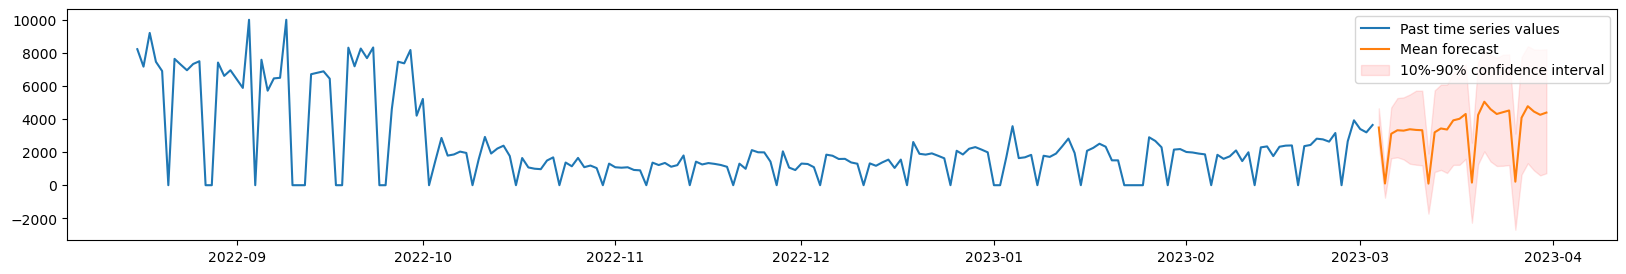

In [45]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
# test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

# item_id = "H1"
item_id = "TG_A_J"
y_past = train_data.loc[item_id]["price"]
y_pred = pred.loc[item_id]
# y_test = test_data.loc[item_id]["price(원/kg)"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
# plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [50]:
submission = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/sample_submission.csv')
submission['answer'] = pred.reset_index()['mean']
submission.loc[ submission['answer'] < 0.0, 'answer'] = 0.0
submission.to_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/dacon_submission.csv', index=False)
submission

,ID,answer
0,TG_A_J_20230304,470.951101
1,TG_A_J_20230305,77.425914
2,TG_A_J_20230306,471.263477
3,TG_A_J_20230307,480.834453
4,TG_A_J_20230308,492.578623
...,...,...
1087,RD_F_J_20230327,447.314676
1088,RD_F_J_20230328,474.649664
1089,RD_F_J_20230329,297.141638
1090,RD_F_J_20230330,403.050754
